In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch.nn.init as init
import time

# Part-I:  Building a Basic NN

## **Step 1: Loading the Dataset**

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

url = 'https://drive.google.com/file/d/1ss11rlBXA3qSzCdUtta9glxMonU9xG-6/view?usp=sharing'

# extract the file ID from the URL
file_id = url.split('/')[-2]

# create the download link
download_link = f'https://drive.google.com/uc?id={file_id}'

# read the CSV file into a Pandas DataFrame
df = pd.read_csv(download_link)

df

Using cpu device


,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1
...,...,...,...,...,...,...,...,...
761,9,89,62,0,0,22.5,e,0
762,10,101,76,48,180,d,0.171,0
763,2,122,70,27,b,36.8,0.34,0
764,c,121,72,23,112,26.2,0.245,0


In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## Step 2: Preprocessing the Dataset

In [4]:
# we now want to turn df to numeric and for vlaues that ar chars will be set to nan and nan will be dropped
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# split the data into X (features) and y (target)
X = df.drop('target',axis=1)
y = df['target']
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# create a StandardScaler object and fit it to the data
scaler = StandardScaler()
scaler.fit(X)

# transform the data using the scaler
X_new = pd.DataFrame(scaler.transform(X), columns=X.columns)

X_new

,f1,f2,f3,f4,f5,f6,f7
0,0.644092,0.844637,0.148213,0.908737,-0.694636,0.202839,0.463021
1,-0.842876,-1.123976,-0.160536,0.532503,-0.694636,-0.683852,-0.368158
2,1.238879,1.938311,-0.263452,-1.285961,-0.694636,-1.101863,0.598540
3,-0.842876,-0.998985,-0.160536,0.156269,0.119179,-0.493847,-0.922278
4,-1.140270,0.500911,-1.498446,0.908737,0.759842,1.406204,5.465156
...,...,...,...,...,...,...,...
755,-0.842876,0.219680,0.971542,1.159559,0.257700,0.570182,1.757975
756,0.941485,0.500911,1.074458,1.284971,-0.694636,0.000167,-0.247698
757,-1.140270,0.063441,0.148213,-1.285961,-0.694636,0.544848,-0.648230
758,-0.842876,-0.467772,0.354045,-1.285961,-0.694636,0.696852,-0.831932


In [5]:
# train-Test split the data using sklearn (later have to try using pytorch)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# set the dataframes to numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_val = y_val.to_numpy()

# convert to tensors for x
Xtrain = torch.tensor(X_train, dtype=torch.float32)
Xtest = torch.tensor(X_test, dtype=torch.float32)
Xval = torch.tensor(X_val, dtype=torch.float32)
# convert to tensors for y and reshape to fit
ytrain = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
ytest = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
yval = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

In [6]:
Xtrain, Xtest

(tensor([[ 0.3467, -0.3428, -0.0576,  ..., -0.6946, -0.7599, -0.5458],
         [-0.2481, -1.2802, -3.5568,  ..., -0.6946, -4.0533, -0.9012],
         [ 0.6441, -0.8740, -0.9839,  ..., -0.1405, -0.4178, -0.3531],
         ...,
         [-0.2481, -0.0303,  0.0453,  ...,  0.4741,  1.3809, -0.0640],
         [-0.5455, -1.1865, -0.1605,  ..., -0.2618,  0.0255,  0.0715],
         [-1.1403,  1.8446,  0.4570,  ..., -0.5734,  3.4709,  5.8627]]),
 tensor([[-0.5455,  0.1884, -0.5722,  ...,  1.6862, -0.5445,  3.3932],
         [-0.5455, -0.2803,  0.3026,  ..., -0.6946,  0.4688, -0.9795],
         [-0.8429, -1.5614, -1.0868,  ..., -0.0367, -1.4692, -0.4525],
         ...,
         [-1.1403,  1.3758,  1.0745,  ...,  5.1925,  2.5716, -0.1393],
         [-1.1403, -0.4678,  0.0453,  ...,  0.5867,  0.9375,  0.3968],
         [ 2.4285, -0.4678,  0.5599,  ..., -0.6946, -1.0639, -1.0126]]))

In [7]:
ytrain[:5], ytest[:5]

(tensor([[0.],
         [0.],
         [0.],
         [1.],
         [1.]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [1.]]))

In [50]:
def plot_fn(train_loss,val_loss,train_acc,val_acc):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    # Plot the training and test loss on the same plot
    ax2.plot(train_loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Plot the training and test accuracy on the same plot
    ax1.plot(train_acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validattion Accuracy')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Display the plot
    plt.show()


## Step 3: Defining NN (Base model: part-I)

In [336]:
# BASE MODEL- partI
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits

## Step 4: Training the NN

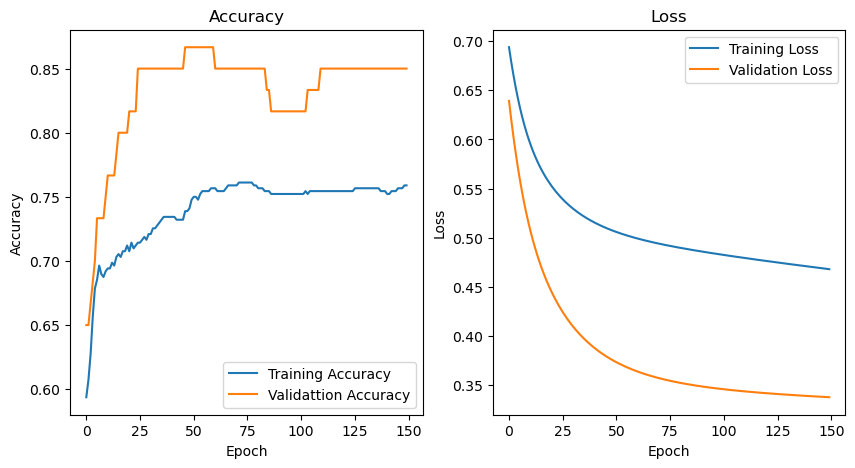

test accuracy 0.75


In [350]:
model = NeuralNetwork(nn.Tanh(), 0.0, init.kaiming_uniform_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

torch.save(model.state_dict(), "msikha_zemingzh_assignment2_part1.pt")
y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))

# Part II: Optimizing NN

## Step 1&2: Hyperparameter tuning


### 1. Activation function Tuning

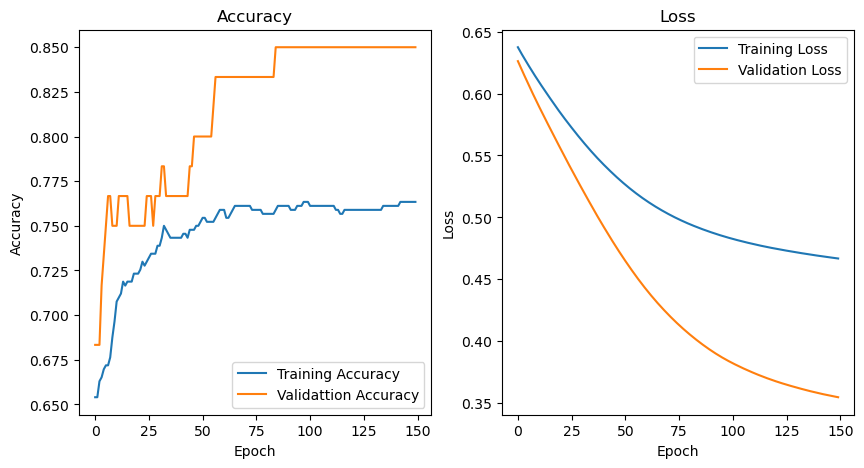

test accuracy 0.7566


In [289]:
# part-II: Activation function tuning- 1
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.ReLU() , 0.0, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

# torch.save(model.state_dict(), "madhubabusikha_zemingzhang.pth")
y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


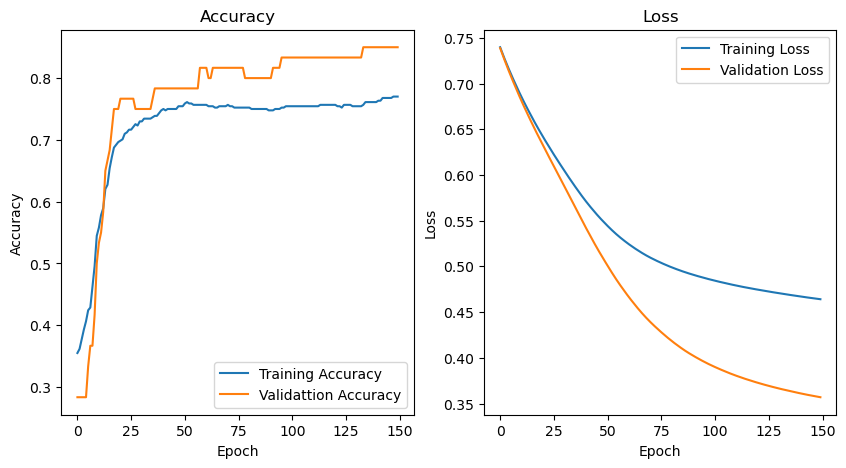

test accuracy 0.7632


In [291]:
# part-II: Activation function tuning- 2
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.LeakyReLU(negative_slope=0.01, inplace=False) , 0.0, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

# torch.save(model.state_dict(), "madhubabusikha_zemingzhang.pth")
y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


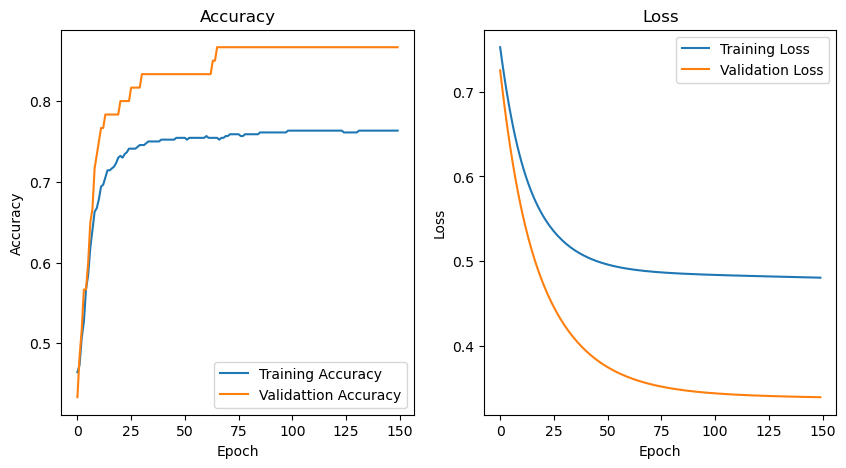

test accuracy 0.7632


In [285]:
# part-II: Activation function tuning- 3
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.ELU(alpha=1.0, inplace=False), 0.0, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

# torch.save(model.state_dict(), "madhubabusikha_zemingzhang.pth")
y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


### 2. Optimization function tuning

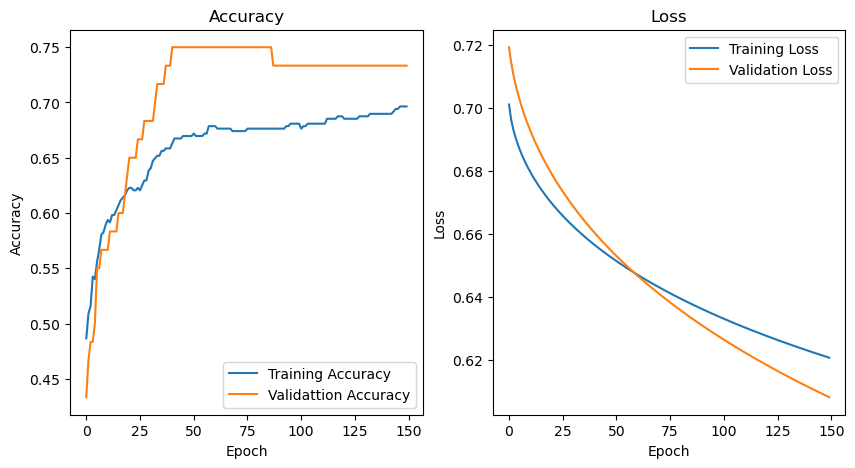

test accuracy 0.6974


In [299]:
# Optimization function tuning-1
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.Tanh() , 0.0, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


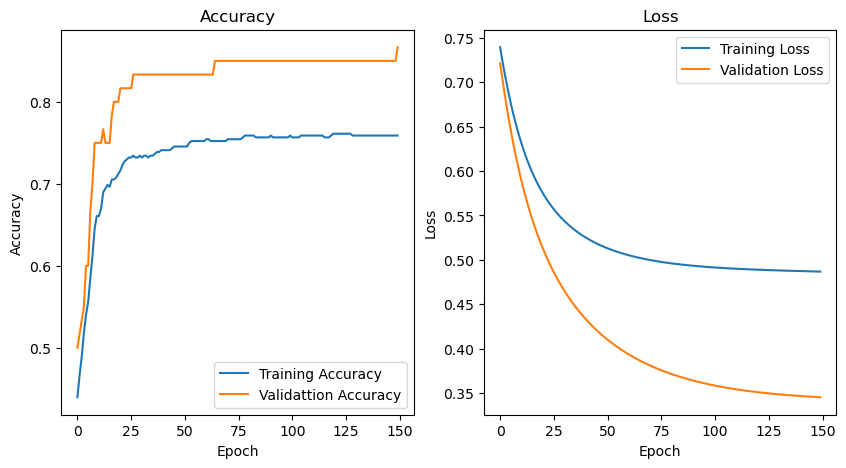

test accuracy 0.7763


In [301]:
# Optimization function tuning-2
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.Tanh() , 0.0, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adamax(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


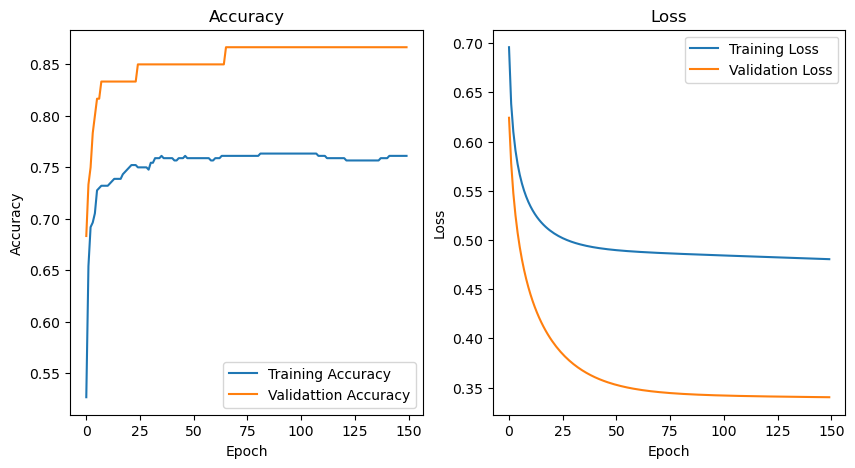

test accuracy 0.7697


In [302]:
# Optimization function tuning-3
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.Tanh() , 0.0, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


### 3. Dropout tuning

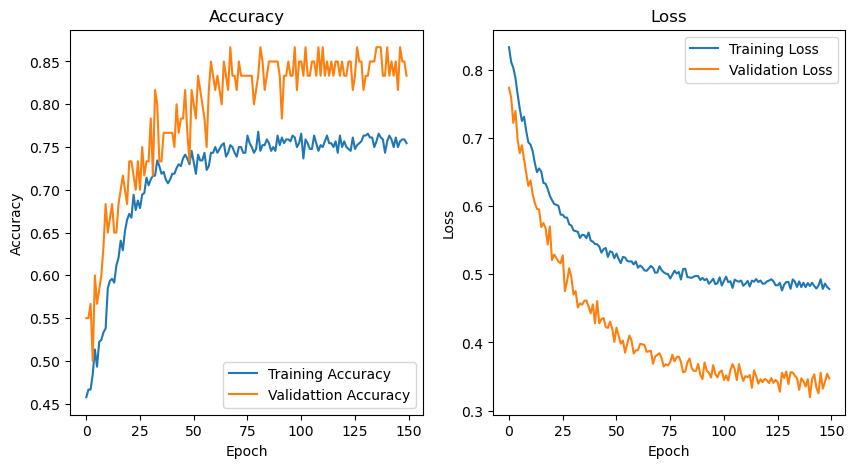

test accuracy 0.7763


In [343]:
# dropout- 1
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.Tanh() , 0.05, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)
torch.save(model.state_dict(), "msikha_zemingzh_assignment2_part2.pt")

y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


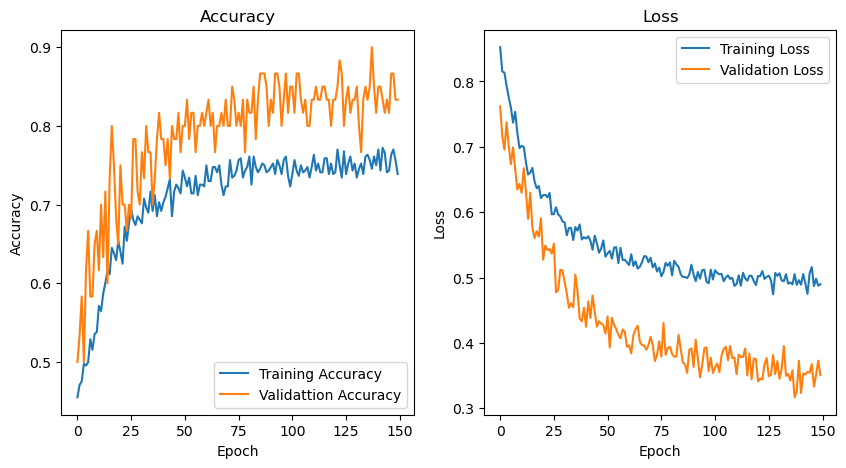

test accuracy 0.75


In [305]:
# dropout- 2
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.Tanh() , 0.15, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


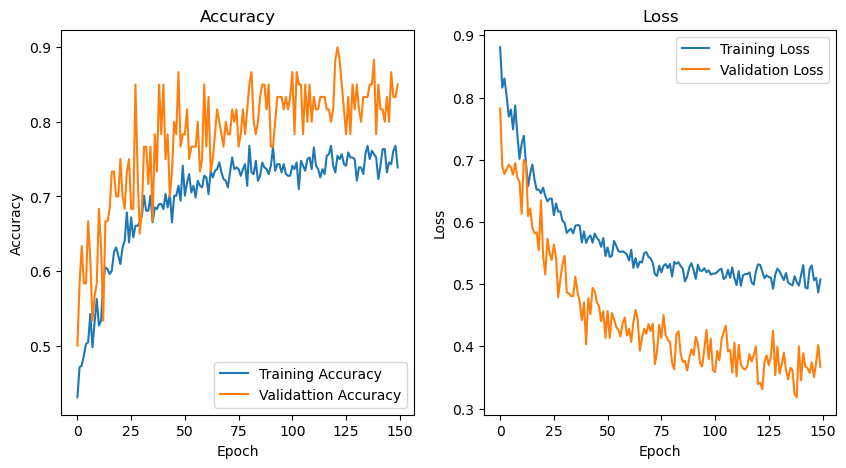

test accuracy 0.7632


In [306]:
# dropout- 3
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.Tanh() , 0.25, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


### 4. Initializer tuning

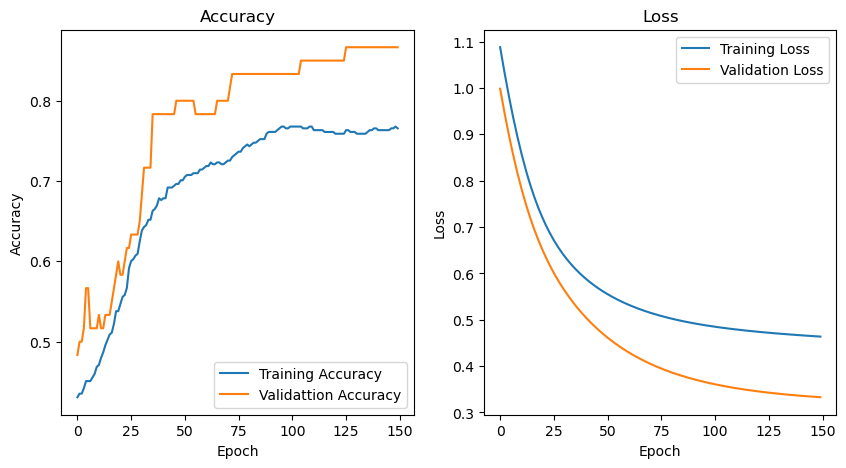

test accuracy 0.7566


In [307]:
# Initializer tuning-1
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.Tanh() , 0.0, init.kaiming_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


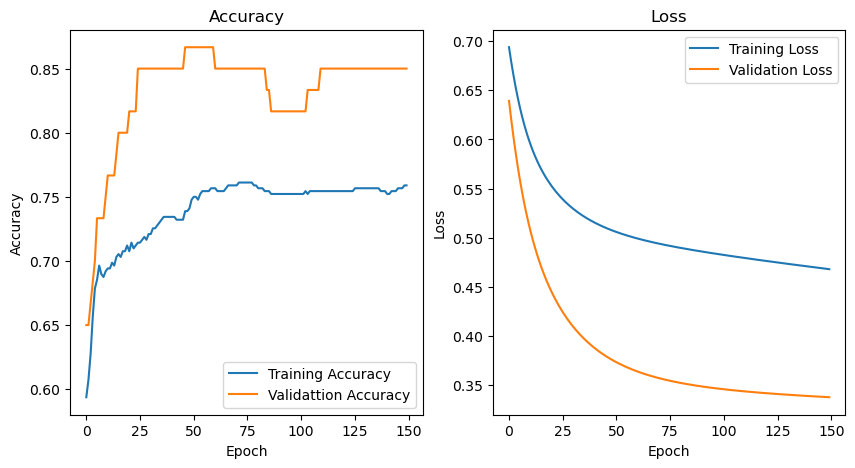

test accuracy 0.75


In [308]:
# Initializer tuning-2
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.Tanh() , 0.0, init.kaiming_uniform_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


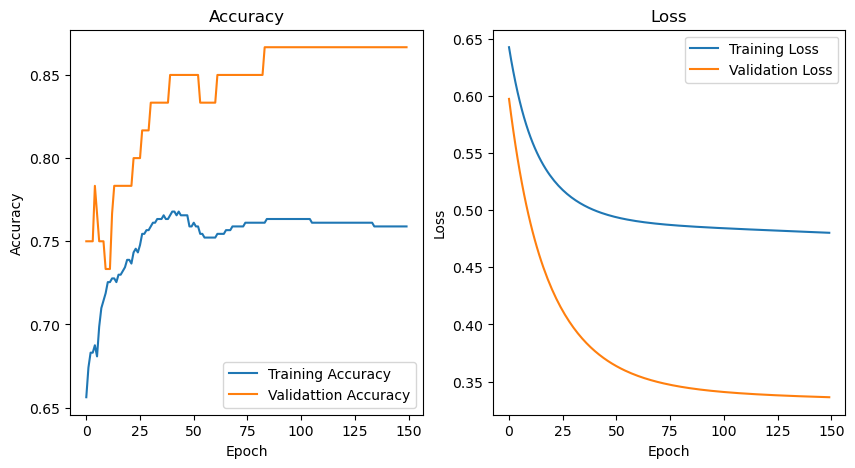

test accuracy 0.7632


In [310]:
# Initializer tuning-3
import torch.nn.init as init

class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(nn.Tanh() , 0.0, init.xavier_uniform_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
n_epochs = 150    # number of epochs to run
batch_size = 64  # size of each batch
batches_per_epoch = len(Xtrain) // batch_size

# collect statistics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


for epoch in range(n_epochs):
    train_loss_epoch = []
    train_acc_epoch = []

    for i in range(batches_per_epoch):
        # take a batch
        start = i * batch_size
        Xbatch = Xtrain[start:start+batch_size]
        ybatch = ytrain[start:start+batch_size]
        # forward pass
        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        acc = (y_pred.round() == ybatch).float().mean()
        # store training metrics
        train_loss_epoch.append(float(loss))
        train_acc_epoch.append(float(acc))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
#                             print(f"Epoch {epoch}, Batch {i}: loss={float(loss):.4f}, acc={float(acc)*100:.2f}%")

    # calculate the average train loss for the epoch
    train_loss.append(np.mean(train_loss_epoch))
    train_acc.append(np.mean(train_acc_epoch))

    # evaluate model on validation set at end of epoch
    with torch.no_grad():
        yval_pred = model(Xval)
        val_loss_epoch = loss_fn(yval_pred, yval)
        val_acc_epoch = (yval_pred.round() == yval).float().mean()

    # store validation metrics
    val_loss.append(float(val_loss_epoch))
    val_acc.append(float(val_acc_epoch))


plot_fn(train_loss,val_loss,train_acc,val_acc)

y_pred_test = model(Xtest)
accuracy = (y_pred_test.round() == ytest).float().mean()
accuracy = float(accuracy)
print('test accuracy', np.round(accuracy,4))


## Step 3: Optimization Methods

In [242]:
class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork(nn.Tanh(), 0.05, init.xavier_normal_)

In [235]:
def test(model, X_test, y_test):
    X_test = X_test  # convert to tensor
    y_test = y_test  # convert to tensor
    y_pred = model(X_test)
    loss_fn = nn.BCELoss()
    test_loss = loss_fn(y_pred, y_test)
    accuracy = (y_pred.round() == y_test).float().mean()
    accuracy = float(accuracy)
    return test_loss.item(), np.round(accuracy,4)

In [236]:
def lr_scheduler(epoch, lr):
    if epoch % 30 == 0 and epoch > 0:
        lr = lr * 2
    return lr

In [311]:
def plot_training_curves(train_loss_og=None, val_loss_og=None, train_acc_og=None, val_acc_og=None, 
                         train_loss=None, val_loss=None, train_acc=None, val_acc=None, 
                         test_loss_og=None, test_loss=None, test_acc_og=None, test_acc=None,
                         label="Epochs", show_all=False, show_stop_line=False, stop_epoch=None):
  
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))

    if show_stop_line and stop_epoch is not None:
        axs[0].axvline(stop_epoch, color='r', linestyle='dashdot', label='training Stops')
        axs[1].axvline(stop_epoch, color='r', linestyle='dashdot', label='training Stops')
    
    if test_loss_og is not None:
        axs[0].axhline(test_loss_og, color='g', linestyle='--', label='test loss base model')
    if test_loss is not None:
        axs[0].axhline(test_loss, color='b', linestyle='--', label='test loss')
    
    if test_acc_og is not None:
        axs[1].axhline(test_acc_og, color='g', linestyle='--', label='test acc base model')
    if test_acc is not None:
        axs[1].axhline(test_acc, color='b', linestyle='--', label='test acc')

    if train_loss_og is not None:
        axs[0].plot(train_loss_og, label='train loss base model')
    if val_loss_og is not None:
        axs[0].plot(val_loss_og, label='val loss base model')
    if train_loss is not None:
        axs[0].plot(train_loss, label='train loss')
    if val_loss is not None:
        axs[0].plot(val_loss, label='val loss')
    axs[0].set_xlabel(label, fontsize=16)
    axs[0].set_ylabel('Loss', fontsize=16)
    axs[0].legend(fontsize=14)

    if show_all:
        axs[0].set_xticks(range(1, len(train_loss)+1))

    if train_acc_og is not None:
        axs[1].plot(train_acc_og, label='train acc base model')
    if val_acc_og is not None:
        axs[1].plot(val_acc_og, label='val acc base model')
    if train_acc is not None:
        axs[1].plot(train_acc, label='train acc')
    if val_acc is not None:
        axs[1].plot(val_acc, label='val acc')
    axs[1].set_xlabel(label, fontsize=16)
    axs[1].set_ylabel('Accuracy', fontsize=16)
    axs[1].legend(fontsize=14)

    if show_all:
        axs[1].set_xticks(range(1, len(train_acc)+1))
    
    plt.show()


In [240]:
def train_model(model, Xtrain, ytrain, Xval, yval, loss_fn, optimizer_func, 
                n_epochs = 150, batch_size = 64, lr = 0.0001, patience = 11, 
                use_early_stopping=False, use_lr_scheduler = False):
  
    """
    Train a PyTorch model using binary cross entropy loss and Adagrad optimizer.

    Args:
        model: PyTorch model to train
        Xtrain: Training input data
        ytrain: Training target data
        Xval: Validation input data
        yval: Validation target data
        loss_fn: loss_fn function
        optimizer_func: optimizer function
        n_epochs: Number of epochs to run (default=150)
        batch_size: Size of each batch (default=64)
        lr: Learning rate for the optimizer (default=0.001)
        patience: Number of epochs to wait before stopping if no improvement in validation loss (default=11)
        use_early_stopping: use early stopping
        use_lr_scheduler: use lr scheduler
        
    Returns:
        train_loss: List of training loss for each epoch
        val_loss: List of validation loss for each epoch
        train_acc: List of training accuracy for each epoch
        val_acc: List of validation accuracy for each epoch
    """

    optimizer = optimizer_func(model.parameters(), lr = lr)
    batches_per_epoch = len(Xtrain) // batch_size

    # collect statistics
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    best_val_loss = float('inf')
    counter = 0

    start_time = time.time()

    for epoch in range(n_epochs):
        train_loss_epoch = []
        train_acc_epoch = []

        if use_lr_scheduler:
            print("Using lr scheduler")
            # update the optimizer in the training loop by calling this function before each backward pass
            lr = lr_scheduler(epoch, lr)
            optimizer = optimizer_func(model.parameters(), lr = lr)

        for j in range(batches_per_epoch):
            # Take a batch
            start = j * batch_size
            Xbatch = Xtrain[start:start+batch_size]
            ybatch = ytrain[start:start+batch_size]

            # Forward pass
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)
            acc = (y_pred.round() == ybatch).float().mean()

            # Store training metrics
            train_loss_epoch.append(float(loss))
            train_acc_epoch.append(float(acc))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

        # Calculate the average train loss for the epoch
        train_loss_epoch = np.mean(train_loss_epoch)
        train_acc_epoch = np.mean(train_acc_epoch)

        # Evaluate the model on the validation set
        with torch.no_grad():
            yval_pred = model(Xval)
            val_loss_epoch = loss_fn(yval_pred, yval)
            val_acc_epoch = (yval_pred.round() == yval).float().mean()

        # Print epoch metrics
        print(f"Epoch {epoch}: training loss {train_loss_epoch:.4f}, training acc {train_acc_epoch:.2%}, validation loss {val_loss_epoch:.4f}, validation acc {val_acc_epoch:.2%}")


        if use_early_stopping:
            print("Using early stopping")
          # Check if the validation loss has improved
            if val_loss_epoch < best_val_loss:
                best_val_loss = val_loss_epoch
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"No improvement after {patience} epochs. Stopping early.")
                    end_time = time.time()
                    training_time = end_time - start_time
                    print(f"Training time: {training_time:.2f} seconds")
                    break

        # Store epoch statistics
        train_loss.append(train_loss_epoch)
        val_loss.append(val_loss_epoch)
        train_acc.append(train_acc_epoch)
        val_acc.append(val_acc_epoch)

    else: 
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")
      
    return train_loss, val_loss, train_acc, val_acc, training_time

Epoch 0: training loss 0.8332, training acc 45.76%, validation loss 0.7736, validation acc 55.00%
Epoch 1: training loss 0.8115, training acc 46.65%, validation loss 0.7596, validation acc 55.00%
Epoch 2: training loss 0.8030, training acc 46.65%, validation loss 0.7223, validation acc 56.67%
Epoch 3: training loss 0.7877, training acc 48.44%, validation loss 0.7397, validation acc 50.00%
Epoch 4: training loss 0.7643, training acc 51.34%, validation loss 0.6975, validation acc 60.00%
Epoch 5: training loss 0.7430, training acc 49.33%, validation loss 0.6779, validation acc 56.67%
Epoch 6: training loss 0.7249, training acc 52.23%, validation loss 0.6893, validation acc 58.33%
Epoch 7: training loss 0.7312, training acc 52.46%, validation loss 0.6685, validation acc 60.00%
Epoch 8: training loss 0.7100, training acc 53.35%, validation loss 0.6482, validation acc 63.33%
Epoch 9: training loss 0.6935, training acc 53.79%, validation loss 0.6297, validation acc 68.33%
Epoch 10: training l

Epoch 90: training loss 0.4947, training acc 75.22%, validation loss 0.3462, validation acc 83.33%
Epoch 91: training loss 0.4913, training acc 76.12%, validation loss 0.3705, validation acc 78.33%
Epoch 92: training loss 0.4933, training acc 75.45%, validation loss 0.3585, validation acc 83.33%
Epoch 93: training loss 0.4861, training acc 75.89%, validation loss 0.3556, validation acc 83.33%
Epoch 94: training loss 0.4893, training acc 75.89%, validation loss 0.3485, validation acc 85.00%
Epoch 95: training loss 0.4934, training acc 75.67%, validation loss 0.3666, validation acc 83.33%
Epoch 96: training loss 0.4854, training acc 76.34%, validation loss 0.3535, validation acc 83.33%
Epoch 97: training loss 0.4871, training acc 76.12%, validation loss 0.3488, validation acc 86.67%
Epoch 98: training loss 0.4955, training acc 75.00%, validation loss 0.3566, validation acc 81.67%
Epoch 99: training loss 0.4835, training acc 75.45%, validation loss 0.3589, validation acc 85.00%
Epoch 100:

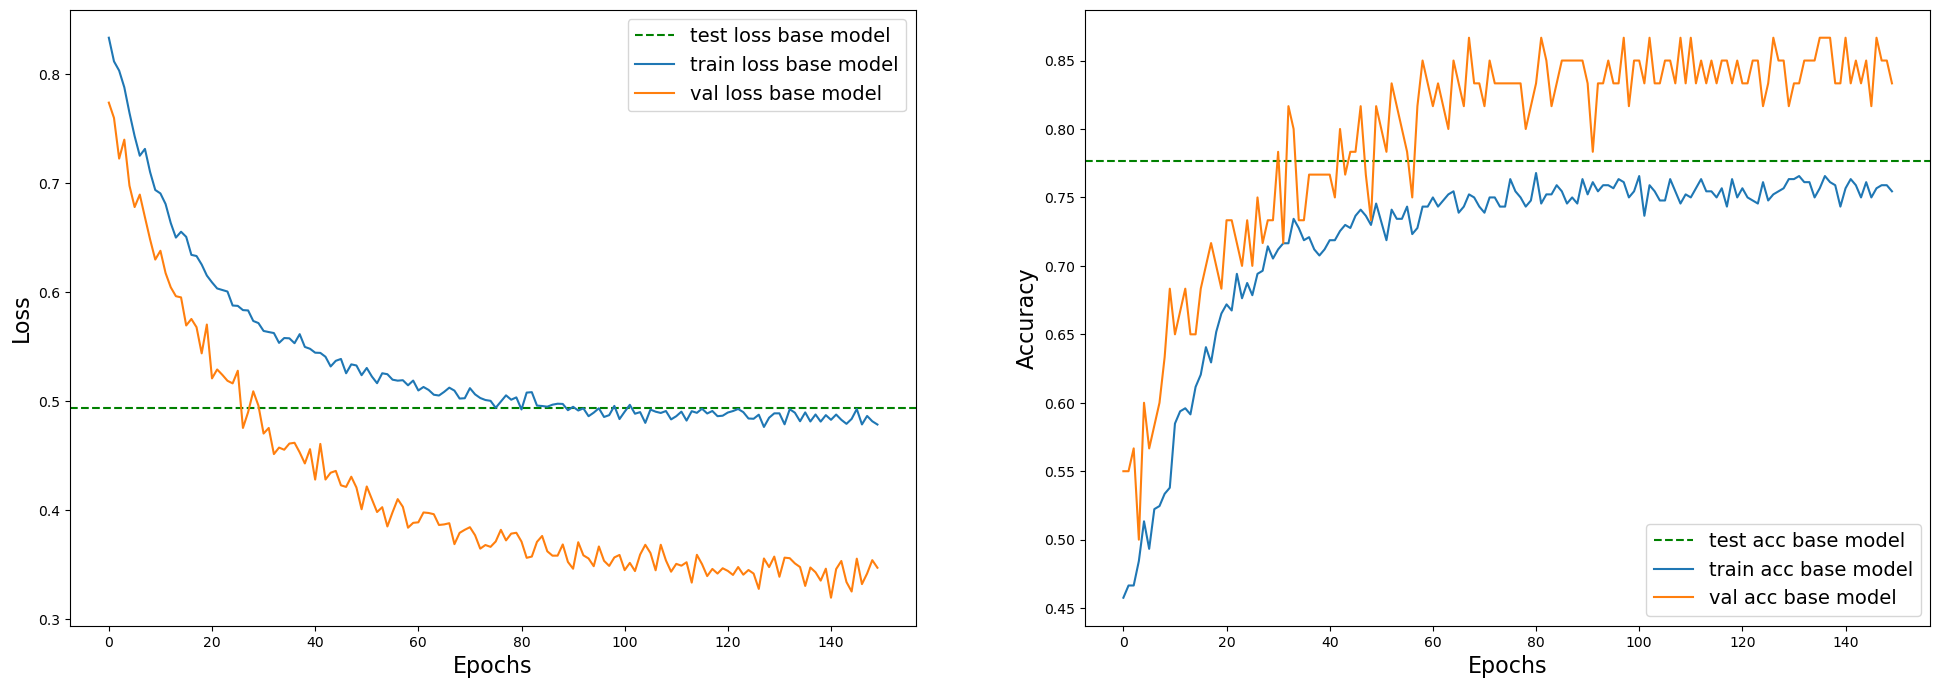

In [313]:
# create a new instance of the model
import time
model = NeuralNetwork(nn.Tanh(), 0.05, init.xavier_normal_)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer_func = optim.AdamW
lr = 0.0001

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


train_loss_og, val_loss_og, train_acc_og, val_acc_og, training_time = train_model(model, Xtrain, ytrain, Xval, yval, loss_fn = loss_fn, 
            optimizer_func = optimizer_func, lr = lr)

test_loss_og , test_acc_og = test(model, Xtest, ytest) 
print(test_loss_og, test_acc_og)
plot_training_curves(train_loss_og, val_loss_og, train_acc_og, val_acc_og, test_loss_og= test_loss_og, test_acc_og= test_acc_og)

### OPTIMIZATION METHOD-1: EARLY STOPPING


Epoch 0: training loss 0.6245, training acc 67.63%, validation loss 0.6310, validation acc 66.67%
Using early stopping
Epoch 1: training loss 0.6245, training acc 65.62%, validation loss 0.5893, validation acc 73.33%
Using early stopping
Epoch 2: training loss 0.6108, training acc 67.63%, validation loss 0.6041, validation acc 68.33%
Using early stopping
Epoch 3: training loss 0.6101, training acc 66.74%, validation loss 0.5796, validation acc 68.33%
Using early stopping
Epoch 4: training loss 0.6009, training acc 69.42%, validation loss 0.5773, validation acc 68.33%
Using early stopping
Epoch 5: training loss 0.5880, training acc 70.31%, validation loss 0.5656, validation acc 70.00%
Using early stopping
Epoch 6: training loss 0.5895, training acc 69.64%, validation loss 0.5661, validation acc 70.00%
Using early stopping
Epoch 7: training loss 0.5806, training acc 70.31%, validation loss 0.5596, validation acc 76.67%
Using early stopping
Epoch 8: training loss 0.5763, training acc 70.7

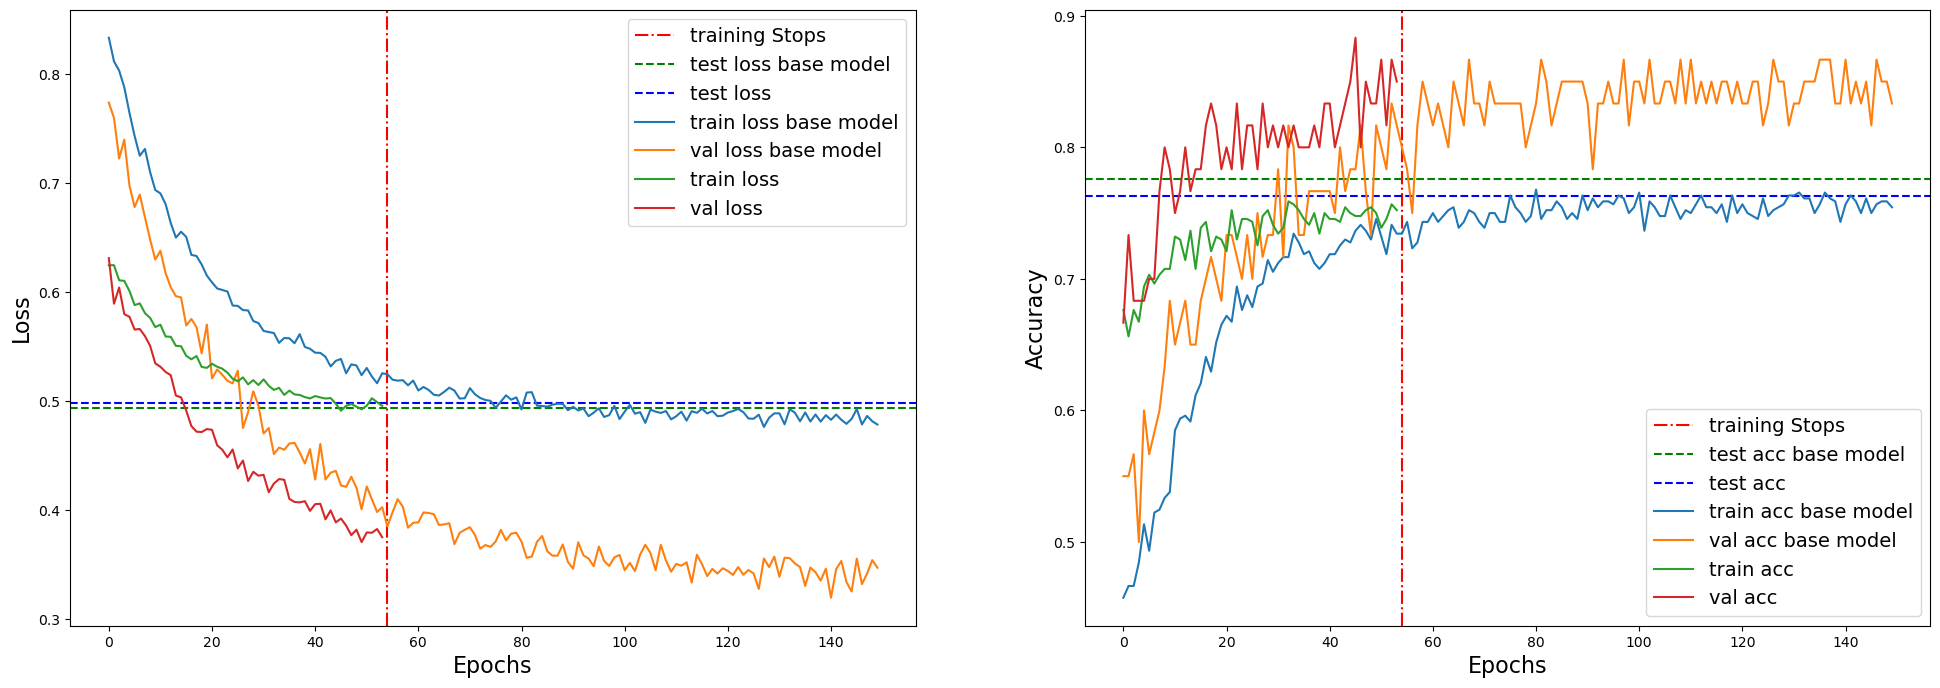

In [318]:
model = NeuralNetwork(nn.Tanh(), 0.05, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer_func = optim.AdamW
lr = 0.0001

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


train_loss, val_loss, train_acc, val_acc, training_time = train_model(model, Xtrain, ytrain, Xval, yval, loss_fn = loss_fn, optimizer_func = optimizer_func, lr = lr, 
            patience = 5, use_early_stopping= True)

test_loss , test_acc = test(model, Xtest, ytest) 
print(test_loss, test_acc)
stop_epoch = len(val_loss)
plot_training_curves(train_loss_og, val_loss_og, train_acc_og, val_acc_og, train_loss, val_loss, train_acc, val_acc, test_loss_og= test_loss_og, test_acc_og= test_acc_og, test_loss= test_loss, test_acc= test_acc, show_stop_line= True, stop_epoch = stop_epoch)

### OPTIMIZATION METHOD-2: LEARNING RATE SCHEDULER

Using lr scheduler
Epoch 0: training loss 0.8332, training acc 45.76%, validation loss 0.7736, validation acc 55.00%
Using lr scheduler
Epoch 1: training loss 0.8114, training acc 46.65%, validation loss 0.7595, validation acc 55.00%
Using lr scheduler
Epoch 2: training loss 0.8027, training acc 46.88%, validation loss 0.7220, validation acc 56.67%
Using lr scheduler
Epoch 3: training loss 0.7871, training acc 48.66%, validation loss 0.7388, validation acc 50.00%
Using lr scheduler
Epoch 4: training loss 0.7633, training acc 51.34%, validation loss 0.6962, validation acc 60.00%
Using lr scheduler
Epoch 5: training loss 0.7413, training acc 49.55%, validation loss 0.6758, validation acc 56.67%
Using lr scheduler
Epoch 6: training loss 0.7226, training acc 52.46%, validation loss 0.6862, validation acc 58.33%
Using lr scheduler
Epoch 7: training loss 0.7277, training acc 52.46%, validation loss 0.6646, validation acc 60.00%
Using lr scheduler
Epoch 8: training loss 0.7058, training acc 5

Epoch 70: training loss 0.4938, training acc 75.45%, validation loss 0.3352, validation acc 85.00%
Using lr scheduler
Epoch 71: training loss 0.4905, training acc 75.45%, validation loss 0.3298, validation acc 86.67%
Using lr scheduler
Epoch 72: training loss 0.4876, training acc 76.79%, validation loss 0.3167, validation acc 85.00%
Using lr scheduler
Epoch 73: training loss 0.4840, training acc 75.67%, validation loss 0.3193, validation acc 86.67%
Using lr scheduler
Epoch 74: training loss 0.4868, training acc 75.00%, validation loss 0.3129, validation acc 88.33%
Using lr scheduler
Epoch 75: training loss 0.4770, training acc 76.34%, validation loss 0.3256, validation acc 86.67%
Using lr scheduler
Epoch 76: training loss 0.4861, training acc 75.22%, validation loss 0.3427, validation acc 83.33%
Using lr scheduler
Epoch 77: training loss 0.4879, training acc 75.67%, validation loss 0.3290, validation acc 85.00%
Using lr scheduler
Epoch 78: training loss 0.4877, training acc 75.89%, val

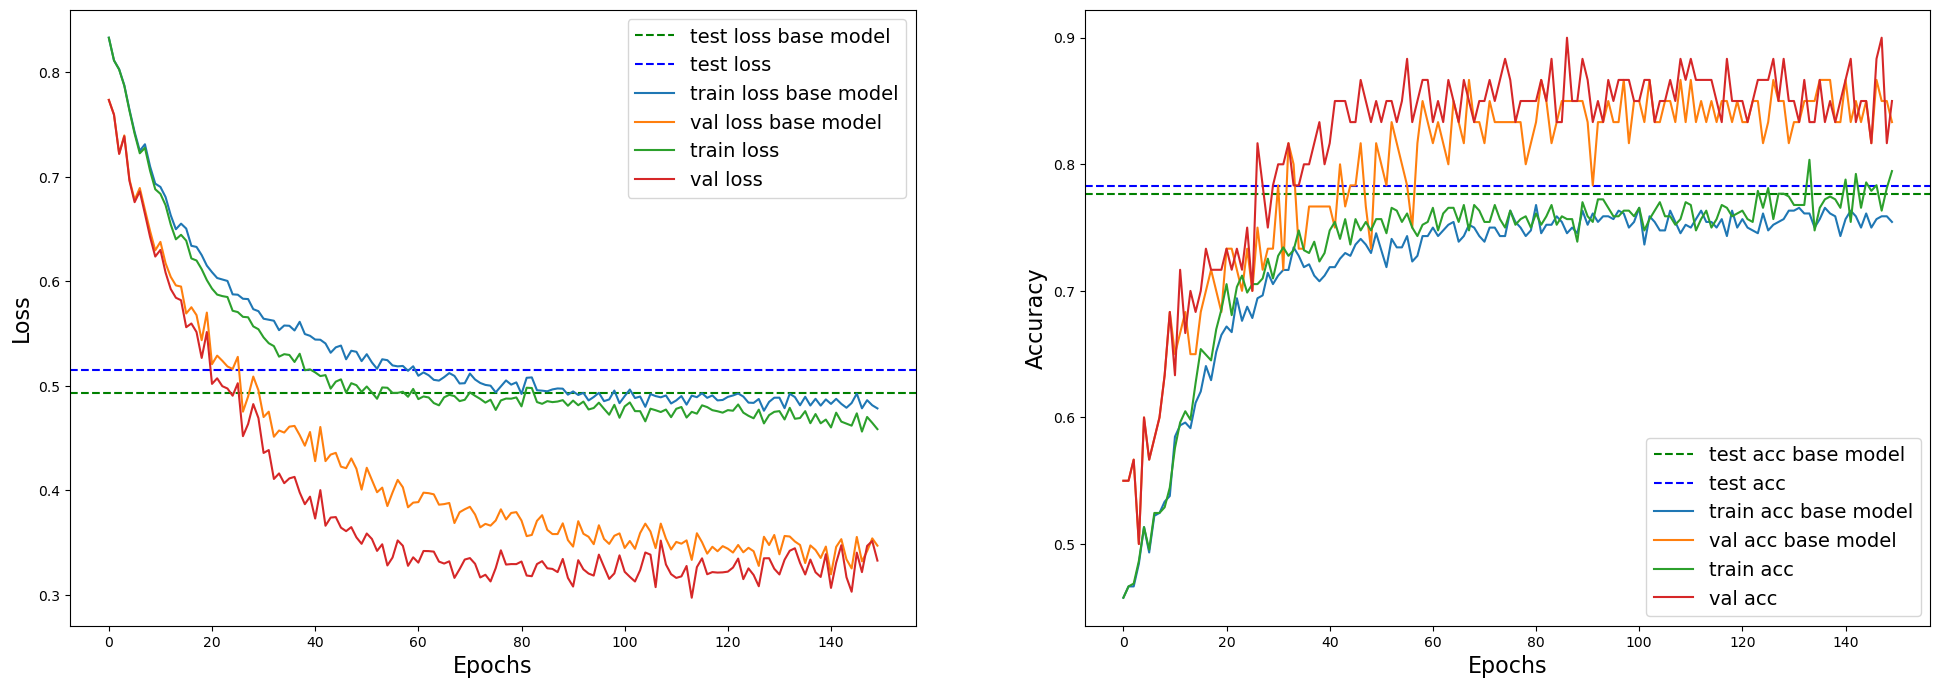

In [320]:
# create a new instance of the model
model = NeuralNetwork(nn.Tanh(), 0.05, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer_func = optim.AdamW
lr = 0.0001

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

train_loss, val_loss, train_acc, val_acc, training_time = train_model(model, Xtrain, ytrain, Xval, yval, loss_fn = loss_fn, 
            optimizer_func = optimizer_func, lr = lr, use_lr_scheduler = True)
test_loss , test_acc = test(model, Xtest, ytest) 
print(test_loss, test_acc)
plot_training_curves(train_loss_og, val_loss_og, train_acc_og, val_acc_og, train_loss, val_loss, train_acc, val_acc, test_loss_og= test_loss_og, test_acc_og= test_acc_og, test_loss= test_loss, test_acc= test_acc)

### OPTIMIZATION METHOD-3: K-FOLD CROSS VALIDATION

Fold 1/8
Epoch 0: training loss 0.7042, training acc 51.79%, validation loss 0.6697, validation acc 66.67%
Epoch 1: training loss 0.6859, training acc 56.47%, validation loss 0.6740, validation acc 70.00%
Epoch 2: training loss 0.6779, training acc 58.26%, validation loss 0.6715, validation acc 58.33%
Epoch 3: training loss 0.6657, training acc 62.05%, validation loss 0.6518, validation acc 56.67%
Epoch 4: training loss 0.6558, training acc 65.62%, validation loss 0.6347, validation acc 70.00%
Epoch 5: training loss 0.6487, training acc 66.74%, validation loss 0.6314, validation acc 68.33%
Epoch 6: training loss 0.6454, training acc 65.18%, validation loss 0.6219, validation acc 73.33%
Epoch 7: training loss 0.6230, training acc 70.31%, validation loss 0.6158, validation acc 71.67%
Epoch 8: training loss 0.6230, training acc 69.87%, validation loss 0.6345, validation acc 63.33%
Epoch 9: training loss 0.6114, training acc 70.76%, validation loss 0.6275, validation acc 71.67%
Epoch 10: t

Epoch 95: training loss 0.4933, training acc 75.45%, validation loss 0.5631, validation acc 70.00%
Epoch 96: training loss 0.4926, training acc 75.22%, validation loss 0.5532, validation acc 70.00%
Epoch 97: training loss 0.4899, training acc 74.55%, validation loss 0.5625, validation acc 66.67%
Epoch 98: training loss 0.4841, training acc 77.23%, validation loss 0.5589, validation acc 68.33%
Epoch 99: training loss 0.4909, training acc 75.22%, validation loss 0.5390, validation acc 70.00%
Epoch 100: training loss 0.4892, training acc 76.56%, validation loss 0.5575, validation acc 70.00%
Epoch 101: training loss 0.4912, training acc 75.45%, validation loss 0.5453, validation acc 70.00%
Epoch 102: training loss 0.4922, training acc 74.11%, validation loss 0.5718, validation acc 66.67%
Epoch 103: training loss 0.4839, training acc 77.68%, validation loss 0.5374, validation acc 68.33%
Epoch 104: training loss 0.4868, training acc 75.45%, validation loss 0.5411, validation acc 75.00%
Epoch

Epoch 39: training loss 0.4819, training acc 75.89%, validation loss 0.3576, validation acc 90.00%
Epoch 40: training loss 0.4862, training acc 76.56%, validation loss 0.3706, validation acc 85.00%
Epoch 41: training loss 0.4816, training acc 77.23%, validation loss 0.3537, validation acc 85.00%
Epoch 42: training loss 0.4784, training acc 77.23%, validation loss 0.3551, validation acc 90.00%
Epoch 43: training loss 0.4906, training acc 74.33%, validation loss 0.3597, validation acc 88.33%
Epoch 44: training loss 0.4807, training acc 76.34%, validation loss 0.3511, validation acc 88.33%
Epoch 45: training loss 0.4855, training acc 75.67%, validation loss 0.3506, validation acc 85.00%
Epoch 46: training loss 0.4855, training acc 75.45%, validation loss 0.3553, validation acc 88.33%
Epoch 47: training loss 0.4750, training acc 76.79%, validation loss 0.3497, validation acc 86.67%
Epoch 48: training loss 0.4843, training acc 76.12%, validation loss 0.3603, validation acc 88.33%
Epoch 49: 

Epoch 135: training loss 0.4748, training acc 76.79%, validation loss 0.3421, validation acc 86.67%
Epoch 136: training loss 0.4759, training acc 76.34%, validation loss 0.3487, validation acc 86.67%
Epoch 137: training loss 0.4806, training acc 75.00%, validation loss 0.3543, validation acc 85.00%
Epoch 138: training loss 0.4839, training acc 75.89%, validation loss 0.3618, validation acc 81.67%
Epoch 139: training loss 0.4778, training acc 77.23%, validation loss 0.3425, validation acc 88.33%
Epoch 140: training loss 0.4814, training acc 75.45%, validation loss 0.3616, validation acc 85.00%
Epoch 141: training loss 0.4852, training acc 75.45%, validation loss 0.3481, validation acc 88.33%
Epoch 142: training loss 0.4842, training acc 75.67%, validation loss 0.3453, validation acc 90.00%
Epoch 143: training loss 0.4677, training acc 76.79%, validation loss 0.3546, validation acc 85.00%
Epoch 144: training loss 0.4813, training acc 76.34%, validation loss 0.3577, validation acc 85.00%


Epoch 81: training loss 0.4730, training acc 75.45%, validation loss 0.4601, validation acc 78.33%
Epoch 82: training loss 0.4767, training acc 76.12%, validation loss 0.4546, validation acc 76.67%
Epoch 83: training loss 0.4708, training acc 76.79%, validation loss 0.4679, validation acc 75.00%
Epoch 84: training loss 0.4749, training acc 77.01%, validation loss 0.4502, validation acc 76.67%
Epoch 85: training loss 0.4701, training acc 76.56%, validation loss 0.4613, validation acc 73.33%
Epoch 86: training loss 0.4727, training acc 76.56%, validation loss 0.4540, validation acc 75.00%
Epoch 87: training loss 0.4713, training acc 76.12%, validation loss 0.4446, validation acc 73.33%
Epoch 88: training loss 0.4753, training acc 76.79%, validation loss 0.4462, validation acc 76.67%
Epoch 89: training loss 0.4739, training acc 75.67%, validation loss 0.4448, validation acc 78.33%
Epoch 90: training loss 0.4744, training acc 75.45%, validation loss 0.4472, validation acc 78.33%
Epoch 91: 

Epoch 31: training loss 0.4667, training acc 75.89%, validation loss 0.4446, validation acc 78.33%
Epoch 32: training loss 0.4640, training acc 77.46%, validation loss 0.4163, validation acc 80.00%
Epoch 33: training loss 0.4694, training acc 77.23%, validation loss 0.4292, validation acc 78.33%
Epoch 34: training loss 0.4661, training acc 77.01%, validation loss 0.4373, validation acc 76.67%
Epoch 35: training loss 0.4688, training acc 76.12%, validation loss 0.4382, validation acc 76.67%
Epoch 36: training loss 0.4691, training acc 75.22%, validation loss 0.4271, validation acc 80.00%
Epoch 37: training loss 0.4598, training acc 77.23%, validation loss 0.4220, validation acc 78.33%
Epoch 38: training loss 0.4663, training acc 75.22%, validation loss 0.4520, validation acc 76.67%
Epoch 39: training loss 0.4680, training acc 76.12%, validation loss 0.4214, validation acc 78.33%
Epoch 40: training loss 0.4690, training acc 77.23%, validation loss 0.4537, validation acc 80.00%
Epoch 41: 

Epoch 128: training loss 0.4614, training acc 76.12%, validation loss 0.4315, validation acc 78.33%
Epoch 129: training loss 0.4639, training acc 76.79%, validation loss 0.4323, validation acc 76.67%
Epoch 130: training loss 0.4612, training acc 77.68%, validation loss 0.4448, validation acc 75.00%
Epoch 131: training loss 0.4630, training acc 77.01%, validation loss 0.4291, validation acc 76.67%
Epoch 132: training loss 0.4671, training acc 76.34%, validation loss 0.4276, validation acc 76.67%
Epoch 133: training loss 0.4572, training acc 77.23%, validation loss 0.4330, validation acc 76.67%
Epoch 134: training loss 0.4603, training acc 77.01%, validation loss 0.4220, validation acc 80.00%
Epoch 135: training loss 0.4606, training acc 76.56%, validation loss 0.4175, validation acc 76.67%
Epoch 136: training loss 0.4576, training acc 76.12%, validation loss 0.4281, validation acc 76.67%
Epoch 137: training loss 0.4479, training acc 77.46%, validation loss 0.4390, validation acc 76.67%


Epoch 77: training loss 0.4453, training acc 77.46%, validation loss 0.4678, validation acc 78.33%
Epoch 78: training loss 0.4567, training acc 76.34%, validation loss 0.4506, validation acc 80.00%
Epoch 79: training loss 0.4526, training acc 77.68%, validation loss 0.4534, validation acc 78.33%
Epoch 80: training loss 0.4414, training acc 77.68%, validation loss 0.4741, validation acc 78.33%
Epoch 81: training loss 0.4533, training acc 76.34%, validation loss 0.4610, validation acc 76.67%
Epoch 82: training loss 0.4568, training acc 77.46%, validation loss 0.4539, validation acc 81.67%
Epoch 83: training loss 0.4615, training acc 76.79%, validation loss 0.4637, validation acc 81.67%
Epoch 84: training loss 0.4433, training acc 77.46%, validation loss 0.4534, validation acc 80.00%
Epoch 85: training loss 0.4537, training acc 76.56%, validation loss 0.4596, validation acc 81.67%
Epoch 86: training loss 0.4608, training acc 77.23%, validation loss 0.4630, validation acc 80.00%
Epoch 87: 

Epoch 24: training loss 0.4427, training acc 77.23%, validation loss 0.4971, validation acc 73.33%
Epoch 25: training loss 0.4421, training acc 78.79%, validation loss 0.5009, validation acc 71.67%
Epoch 26: training loss 0.4453, training acc 77.90%, validation loss 0.5228, validation acc 71.67%
Epoch 27: training loss 0.4367, training acc 78.57%, validation loss 0.4987, validation acc 73.33%
Epoch 28: training loss 0.4536, training acc 77.01%, validation loss 0.5232, validation acc 71.67%
Epoch 29: training loss 0.4469, training acc 78.12%, validation loss 0.5350, validation acc 68.33%
Epoch 30: training loss 0.4472, training acc 78.12%, validation loss 0.5378, validation acc 71.67%
Epoch 31: training loss 0.4500, training acc 77.68%, validation loss 0.5075, validation acc 70.00%
Epoch 32: training loss 0.4463, training acc 77.90%, validation loss 0.5237, validation acc 71.67%
Epoch 33: training loss 0.4517, training acc 77.90%, validation loss 0.5055, validation acc 71.67%
Epoch 34: 

Epoch 123: training loss 0.4412, training acc 77.46%, validation loss 0.5276, validation acc 68.33%
Epoch 124: training loss 0.4361, training acc 79.02%, validation loss 0.4848, validation acc 75.00%
Epoch 125: training loss 0.4424, training acc 77.46%, validation loss 0.5429, validation acc 73.33%
Epoch 126: training loss 0.4419, training acc 77.23%, validation loss 0.4761, validation acc 78.33%
Epoch 127: training loss 0.4400, training acc 79.02%, validation loss 0.5089, validation acc 73.33%
Epoch 128: training loss 0.4444, training acc 77.23%, validation loss 0.5083, validation acc 71.67%
Epoch 129: training loss 0.4523, training acc 76.56%, validation loss 0.5217, validation acc 73.33%
Epoch 130: training loss 0.4475, training acc 77.68%, validation loss 0.4913, validation acc 73.33%
Epoch 131: training loss 0.4479, training acc 77.01%, validation loss 0.4893, validation acc 73.33%
Epoch 132: training loss 0.4357, training acc 77.68%, validation loss 0.5166, validation acc 68.33%


Epoch 68: training loss 0.4418, training acc 77.90%, validation loss 0.5000, validation acc 76.67%
Epoch 69: training loss 0.4380, training acc 77.68%, validation loss 0.5267, validation acc 70.00%
Epoch 70: training loss 0.4426, training acc 78.57%, validation loss 0.4981, validation acc 71.67%
Epoch 71: training loss 0.4334, training acc 77.90%, validation loss 0.5149, validation acc 75.00%
Epoch 72: training loss 0.4356, training acc 79.46%, validation loss 0.5135, validation acc 73.33%
Epoch 73: training loss 0.4338, training acc 77.90%, validation loss 0.5062, validation acc 66.67%
Epoch 74: training loss 0.4424, training acc 77.23%, validation loss 0.5066, validation acc 75.00%
Epoch 75: training loss 0.4428, training acc 77.68%, validation loss 0.5022, validation acc 70.00%
Epoch 76: training loss 0.4263, training acc 79.69%, validation loss 0.5106, validation acc 71.67%
Epoch 77: training loss 0.4390, training acc 77.46%, validation loss 0.5018, validation acc 73.33%
Epoch 78: 

Epoch 6: training loss 0.4416, training acc 77.23%, validation loss 0.3477, validation acc 81.67%
Epoch 7: training loss 0.4311, training acc 78.57%, validation loss 0.3098, validation acc 88.33%
Epoch 8: training loss 0.4400, training acc 77.68%, validation loss 0.3296, validation acc 85.00%
Epoch 9: training loss 0.4302, training acc 77.90%, validation loss 0.3418, validation acc 83.33%
Epoch 10: training loss 0.4358, training acc 78.35%, validation loss 0.3357, validation acc 81.67%
Epoch 11: training loss 0.4352, training acc 77.01%, validation loss 0.3459, validation acc 83.33%
Epoch 12: training loss 0.4304, training acc 77.23%, validation loss 0.3521, validation acc 85.00%
Epoch 13: training loss 0.4251, training acc 79.91%, validation loss 0.3369, validation acc 85.00%
Epoch 14: training loss 0.4277, training acc 79.91%, validation loss 0.3416, validation acc 88.33%
Epoch 15: training loss 0.4325, training acc 78.12%, validation loss 0.3388, validation acc 86.67%
Epoch 16: trai

Epoch 98: training loss 0.4276, training acc 77.46%, validation loss 0.3002, validation acc 88.33%
Epoch 99: training loss 0.4234, training acc 77.01%, validation loss 0.3511, validation acc 85.00%
Epoch 100: training loss 0.4239, training acc 79.02%, validation loss 0.3473, validation acc 81.67%
Epoch 101: training loss 0.4426, training acc 77.01%, validation loss 0.3107, validation acc 86.67%
Epoch 102: training loss 0.4275, training acc 79.24%, validation loss 0.3393, validation acc 83.33%
Epoch 103: training loss 0.4326, training acc 76.56%, validation loss 0.3246, validation acc 90.00%
Epoch 104: training loss 0.4367, training acc 78.35%, validation loss 0.3426, validation acc 83.33%
Epoch 105: training loss 0.4296, training acc 79.24%, validation loss 0.3197, validation acc 90.00%
Epoch 106: training loss 0.4169, training acc 79.46%, validation loss 0.3185, validation acc 86.67%
Epoch 107: training loss 0.4265, training acc 78.35%, validation loss 0.3642, validation acc 81.67%
Ep

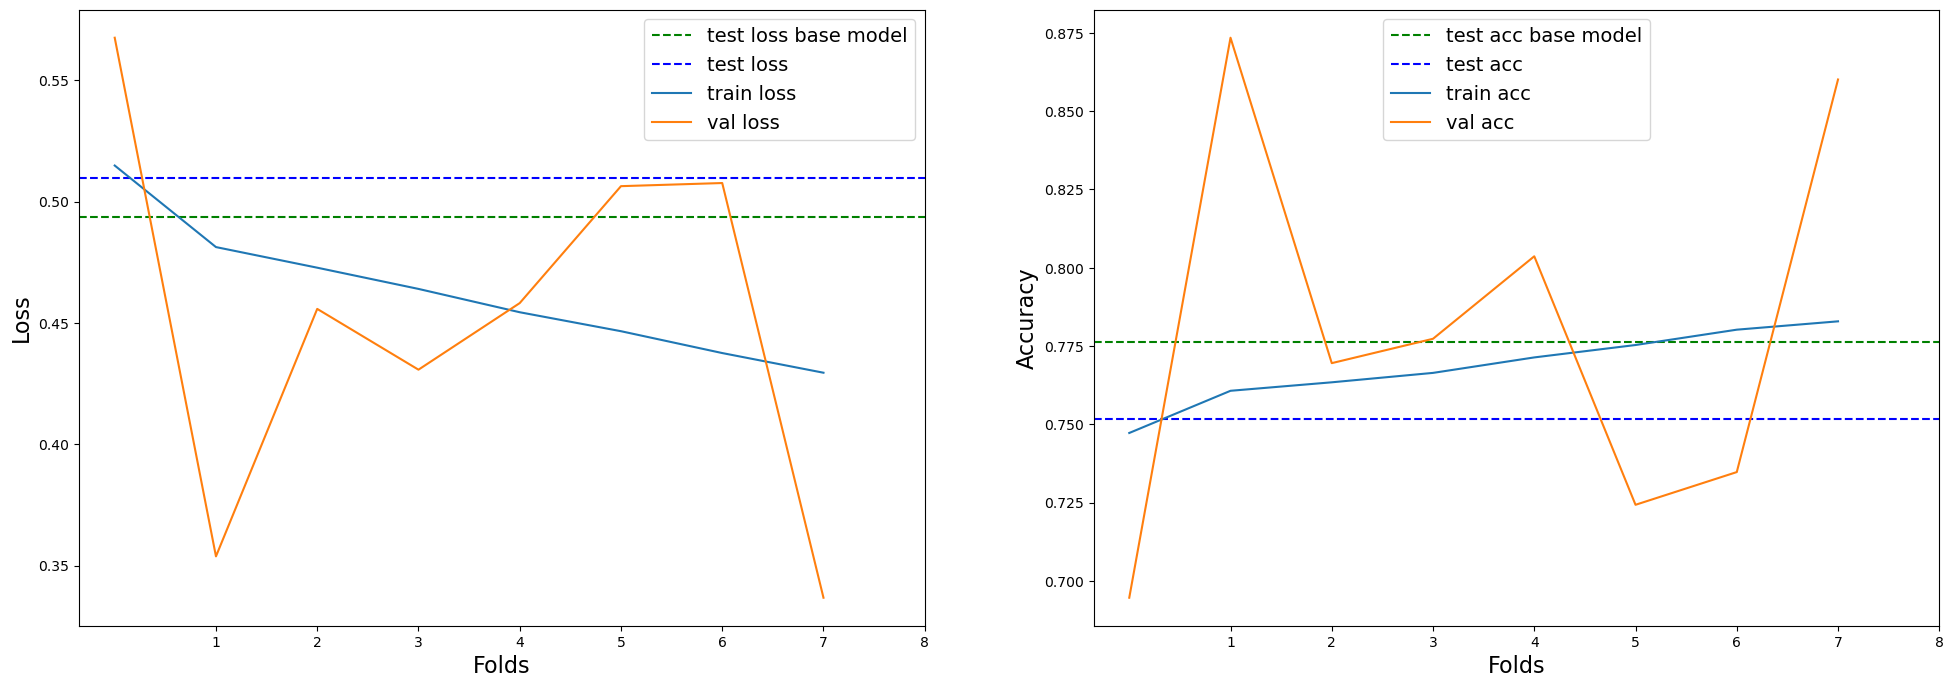

In [323]:
# create a new instance of the model
model = NeuralNetwork(nn.Tanh(), 0.05, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer_func = optim.AdamW
lr = 0.0001
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


# Define the number of folds and initialize the lists to store the scores
k = 8
train_loss_cv = []
val_loss_cv = []
train_acc_cv = []
val_acc_cv = []
test_acc_cv = []
test_loss_cv = []
training_time_cv = []

# Split the data into k folds
n_samples = len(Xtrain)
fold_size = n_samples // k

for i in range(k):
    print(f"Fold {i+1}/{k}")
    
    # Define the train and validation sets for this fold
    val_start = i * fold_size
    val_end = (i + 1) * fold_size
    Xval = Xtrain[val_start:val_end]
    yval = ytrain[val_start:val_end]

    Xtrain_fold = np.concatenate((Xtrain[:val_start], Xtrain[val_end:]), axis=0)
    ytrain_fold = np.concatenate((ytrain[:val_start], ytrain[val_end:]), axis=0)
    
    # convert to tensors for x_fold
    Xtrain_fold = torch.tensor(Xtrain_fold, dtype=torch.float32)
    # convert to tensors for y_fold and reshape to fit
    ytrain_fold = torch.tensor(ytrain_fold, dtype=torch.float32).reshape(-1, 1)

    train_loss, val_loss, train_acc, val_acc, training_time = train_model(model, Xtrain, ytrain, Xval, yval, loss_fn = loss_fn, optimizer_func = optimizer_func, lr = lr)
    test_loss , test_acc = test(model, Xtest, ytest) 
    
    # Calculate the averages and append to the lists
    train_loss_cv.append(np.mean(train_loss))
    val_loss_cv.append(np.mean(val_loss))
    train_acc_cv.append(np.mean(train_acc))
    val_acc_cv.append(np.mean(val_acc))
    test_acc_cv.append(np.mean(test_acc))
    test_loss_cv.append(np.mean(test_loss))
    training_time_cv.append(training_time)

    # Print the results for this fold
    print(f"Train loss: {np.mean(train_loss_cv):.4f}, Val loss: {np.mean(val_loss_cv):.4f}")
    print(f"Train acc: {np.mean(train_acc_cv):.4f}, Val acc: {np.mean(val_acc_cv):.4f}")
    print(f"Test acc: {np.mean(test_acc):.4f}")

avg_train_loss = np.mean(train_loss_cv)
avg_val_loss = np.mean(val_loss_cv)
avg_train_acc = np.mean(train_acc_cv)
avg_val_acc = np.mean(val_acc_cv)
avg_test_acc = np.mean(test_acc_cv)
avg_test_loss = np.mean(test_loss_cv)
training_time_avg = np.mean(training_time_cv)

print(f"Average train loss: {avg_train_loss:.4f}")
print(f"Average val loss: {avg_val_loss:.4f}")
print(f"Average train acc: {avg_train_acc:.4f}")
print(f"Average val acc: {avg_val_acc:.4f}")
print(f"Average test acc: {avg_test_acc:.4f}")
print(f"Average test loss: {avg_test_loss:.4f}")
print(f"Average training time: {training_time_avg:.4f}")

plot_training_curves(train_loss= train_loss_cv, val_loss= val_loss_cv, train_acc= train_acc_cv, val_acc= val_acc_cv, test_loss_og= test_loss_og, test_acc_og= test_acc_og, test_loss= avg_test_loss, test_acc= avg_test_acc, label = "Folds", show_all = True)

### OPTIMIZATION METHOD-4: BATCH NORMALIZATION

In [324]:
# Define the neural network class with BatchNorm
  
class NeuralNetwork(nn.Module): 
    def __init__(self, activation, dropout_rate, initializer): 
        super(NeuralNetwork, self).__init__() 
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(7, 64), # dense layer
            nn.BatchNorm1d(64),
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32), 
            nn.BatchNorm1d(32),
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ) 
        # Initialize the weights of the linear layers using the specified initializer
        for linear_layer in self.linear_relu_stack:
            if isinstance(linear_layer, nn.Linear):
                initializer(linear_layer.weight)
                
    def forward(self, x): 
        logits = self.linear_relu_stack(x)
        return logits


Epoch 0: training loss 1.1688, training acc 40.40%, validation loss 1.0910, validation acc 38.33%
Epoch 1: training loss 1.1135, training acc 39.51%, validation loss 1.0452, validation acc 41.67%
Epoch 2: training loss 1.0849, training acc 40.85%, validation loss 0.9619, validation acc 46.67%
Epoch 3: training loss 1.0577, training acc 41.29%, validation loss 0.9553, validation acc 43.33%
Epoch 4: training loss 1.0177, training acc 42.19%, validation loss 0.8983, validation acc 46.67%
Epoch 5: training loss 0.9795, training acc 42.63%, validation loss 0.8890, validation acc 50.00%
Epoch 6: training loss 0.9290, training acc 43.08%, validation loss 0.8608, validation acc 50.00%
Epoch 7: training loss 0.9229, training acc 44.64%, validation loss 0.8440, validation acc 48.33%
Epoch 8: training loss 0.8858, training acc 47.32%, validation loss 0.8090, validation acc 50.00%
Epoch 9: training loss 0.8541, training acc 45.98%, validation loss 0.7693, validation acc 48.33%
Epoch 10: training l

Epoch 93: training loss 0.5027, training acc 75.00%, validation loss 0.3808, validation acc 86.67%
Epoch 94: training loss 0.5005, training acc 75.00%, validation loss 0.3612, validation acc 88.33%
Epoch 95: training loss 0.5031, training acc 75.00%, validation loss 0.3686, validation acc 83.33%
Epoch 96: training loss 0.4981, training acc 75.00%, validation loss 0.3714, validation acc 86.67%
Epoch 97: training loss 0.4958, training acc 75.67%, validation loss 0.3827, validation acc 85.00%
Epoch 98: training loss 0.5095, training acc 74.33%, validation loss 0.3613, validation acc 83.33%
Epoch 99: training loss 0.4908, training acc 76.12%, validation loss 0.3769, validation acc 83.33%
Epoch 100: training loss 0.5030, training acc 74.33%, validation loss 0.3638, validation acc 85.00%
Epoch 101: training loss 0.5071, training acc 74.78%, validation loss 0.3678, validation acc 85.00%
Epoch 102: training loss 0.4917, training acc 75.45%, validation loss 0.3694, validation acc 86.67%
Epoch 1

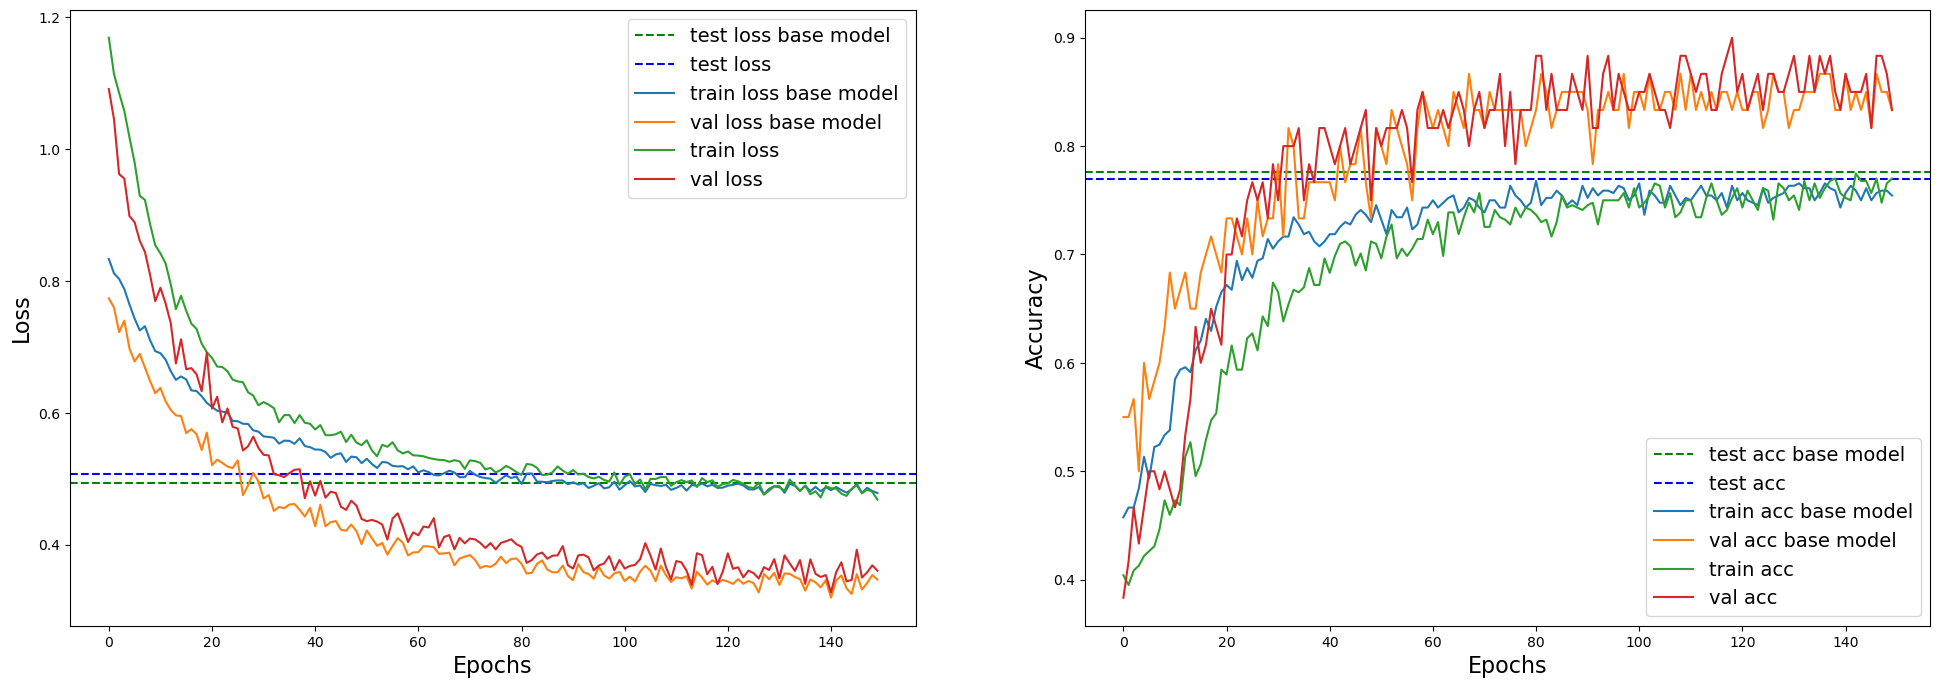

In [326]:
# create a new instance of the model
model = NeuralNetwork(nn.Tanh(), 0.05, init.xavier_normal_)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer_func = optim.AdamW
lr = 0.0001
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

train_loss, val_loss, train_acc, val_acc, training_time = train_model(model, Xtrain, ytrain, Xval, yval, loss_fn = loss_fn, 
            optimizer_func = optimizer_func, lr = lr)

test_loss , test_acc = test(model, Xtest, ytest) 
print(test_loss, test_acc)
plot_training_curves(train_loss_og, val_loss_og, train_acc_og, val_acc_og, train_loss, val_loss, train_acc, val_acc, test_loss_og= test_loss_og, test_acc_og= test_acc_og, test_loss= test_loss, test_acc= test_acc)

## Contribution of Team Members

| Team Member | Assignment Part | Contribution (%) |
| --- | --- | --- |
| msikha | part-I step2 1, 2, 4 and part-II setups | 50% |
| zemingzh| part-I step 3 and part-II optimization methods | 50% |
